# Time Series and Forecasting Models: Facebook Prophet

## 1. Introduction

Prophet is an open source library published by Facebook in 2017 which is built upon scikit-learn time series modelling and automatically detects changes in trends by selecting changepoints from the data. It is an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects, and includes automatic detection for all values. 



## 2. Install/import libraries

In [1]:
!pip install prophet
!pip install mplfinance

In [7]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import yfinance as yf

import datetime
from datetime import date, timedelta

from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 3. Import data

In [16]:
nifty_stocks = yf.download("RELIANCE.NS  BPCL.NS INFY.NS WIPRO.NS BAJAJ-AUTO.NS MARUTI.NS HINDUNILVR.NS BRITANNIA.NS ICICIBANK.NS HDFCBANK.NS", start=datetime.datetime(2011, 4, 1), 
                                      end=datetime.datetime(2023, 3, 31), group_by='tickers')
nifty_stocks.head()

[*********************100%***********************]  10 of 10 completed


INFY.NS                                                   
                  Open        High         Low       Close   Adj Close   
Date                                                                     
2011-04-01  404.387512  407.031250  401.000000  402.268738  300.766815  \
2011-04-04  403.125000  412.000000  402.625000  410.393738  306.841675   
2011-04-05  409.618744  411.625000  403.887512  410.406250  306.851044   
2011-04-06  409.875000  412.375000  406.506256  409.393738  306.094025   
2011-04-07  407.737488  407.737488  404.712494  405.737488  303.360291   

                    HDFCBANK.NS                                      ...   
             Volume        Open        High         Low       Close  ...   
Date                                                                 ...   
2011-04-01  5588288  235.300003  236.500000  232.300003  233.375000  ...  \
2011-04-04  7375992  234.000000  240.500000  234.000000  240.080002  ...   
2011-04-05  4302536  240.000000  240.994995  236.815002  239.574997  ...   
2011-04-06  6766920  239.100006  239.500000  235.100006  237.595001  ...   
2011-04-07  3800288  237.500000  237.800003  233.960007  235.475006  ...   

           BAJAJ-AUTO.NS                                   BRITANNIA.NS   
                     Low        Close    Adj Close  Volume         Open   
Date                                                                      
2011-04-01   1448.050049  1458.949951  1055.137085  431413   184.750000  \
2011-04-04   1440.000000  1456.949951  1053.690796  446712   186.149994   
2011-04-05   1433.750000  1438.150024  1040.094360  451815   188.399994   
2011-04-06   1435.949951  1451.599976  1049.821533  280888   181.774994   
2011-04-07   1436.000000  1440.250000  1041.612915  323494   183.149994   

                                                                   
                  High         Low       Close   Adj Close Volume  
Date                                                               
2011-04-01  187.500000  183.000000  186.050003  153.584717  22116  
2011-04-04  187.000000  185.000000  185.875000  153.440247  13878  
2011-04-05  188.399994  181.300003  182.899994  150.984390  30670  
2011-04-06  184.925003  181.500000  183.024994  151.087616  16370  
2011-04-07  185.000000  183.050003  183.475006  151.459061  11696  

[5 rows x 60 columns]

In [17]:
RI =  nifty_stocks['RELIANCE.NS']
                                     
RI.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-04-01,519.599731,527.945618,510.659454,513.334106,468.434631,8663538
2011-04-04,515.117188,522.447693,509.668854,520.392212,474.875458,6051061
2011-04-05,521.308533,524.528015,515.117188,518.906311,473.519531,4964260
2011-04-06,517.593750,522.175293,515.117188,517.519409,472.253876,4191928
2011-04-07,517.618469,518.856750,512.690186,516.058289,470.920563,4690528


In [18]:
RI['Adj Close']

Date
2011-04-01     468.434631
2011-04-04     474.875458
2011-04-05     473.519531
2011-04-06     472.253876
2011-04-07     470.920563
                 ...     
2023-03-23    2247.800049
2023-03-24    2203.300049
2023-03-27    2237.550049
2023-03-28    2248.000000
2023-03-29    2234.699951
Name: Adj Close, Length: 2958, dtype: float64

## 4. Format data for Prophet

The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [19]:
# Create a dataframe that complies with Prophet requirements

prophet_RI_adj = RI[['Adj Close']].copy()

In [20]:
# Reset the index back so Dates are no longer indexed
prophet_RI_adj.reset_index(inplace=True)

# Rename the columns for use in FB prophet
prophet_RI_adj.rename(columns={'Date': 'ds', 'Adj Close': 'y'}, inplace=True)

prophet_RI_adj.head()

,ds,y
0,2011-04-01,468.434631
1,2011-04-04,474.875458
2,2011-04-05,473.519531
3,2011-04-06,472.253876
4,2011-04-07,470.920563


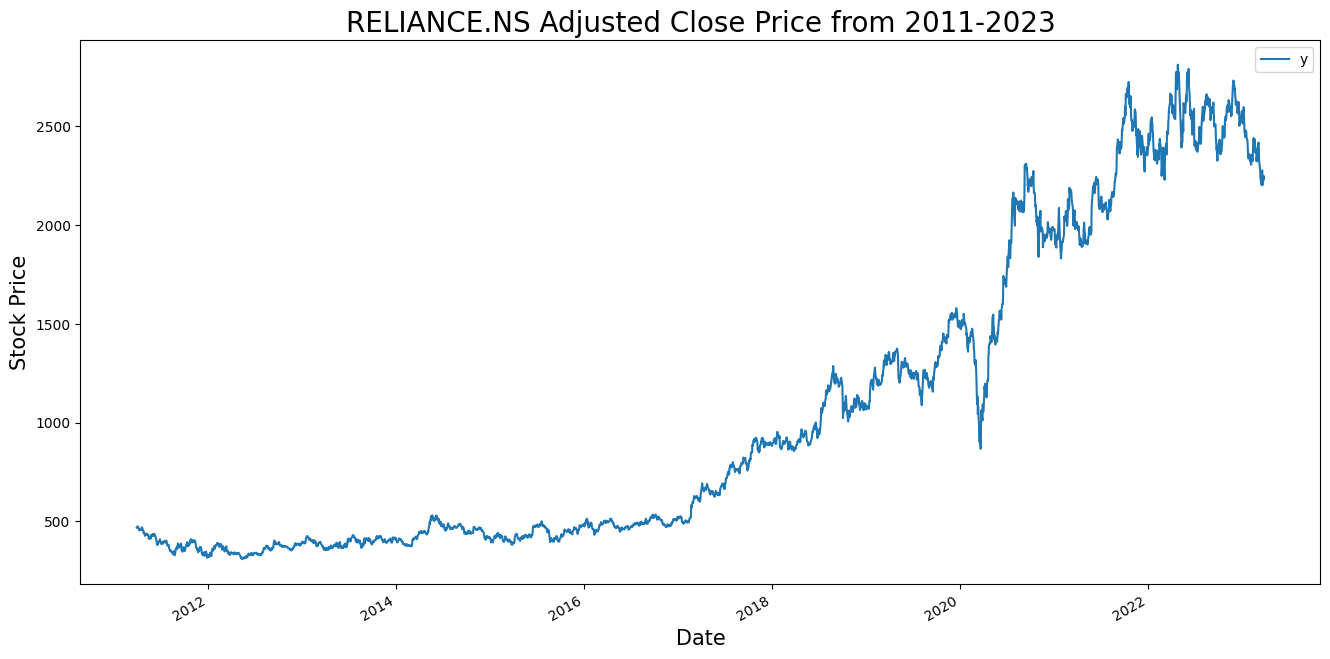

In [21]:
# Plot Adjusted Close price
pd.plotting.register_matplotlib_converters()
ax = prophet_RI_adj.set_index('ds').plot(figsize=(16,8))
ax.set_title('RELIANCE.NS Adjusted Close Price from 2011-2023', color = 'black', fontsize = 20)
ax.set_ylabel('Stock Price', color = 'black', fontsize = 15)
ax.set_xlabel('Date', color = 'black', fontsize = 15)

plt.show()

## 5. Modelling

Prophet follows the sklearn model API. We create an instance of the Prophet class and then call its fit and predict methods.

### 5.1 Fit and train the model

Fit the model by instantiating a new Prophet object. Any settings to the forecasting procedure are passed into the constructor.

In [22]:
# Instantiate model and pass seasonality setting

m = Prophet(daily_seasonality = True)

Call the fit method and pass in the dataframe of dates and prices.



In [23]:
# fit the model

m.fit(prophet_RI_adj)

22:03:08 - cmdstanpy - INFO - Chain [1] start processing
22:03:10 - cmdstanpy - INFO - Chain [1] done processing


### 5.2 Create future dates to forecast

Predictions are then made on a dataframe with a column ds containing the dates for which a prediction is to be made. You can get a suitable dataframe that extends into the future a specified number of days using the helper method Prophet.make_future_dataframe.

In [24]:
# create a dataframe containing future dates to be forecast 
future = m.make_future_dataframe(periods=730, freq='D')     
future.tail()

,ds
3683,2025-03-24
3684,2025-03-25
3685,2025-03-26
3686,2025-03-27
3687,2025-03-28


### 5.3 Predictions

Forecasting future values in the dataframe containing dates for prediction.

In [25]:
# Pass the dataframe to the model with dates to predict future values
forecast = m.predict(future)

### Plot Actual vs Predicted prices

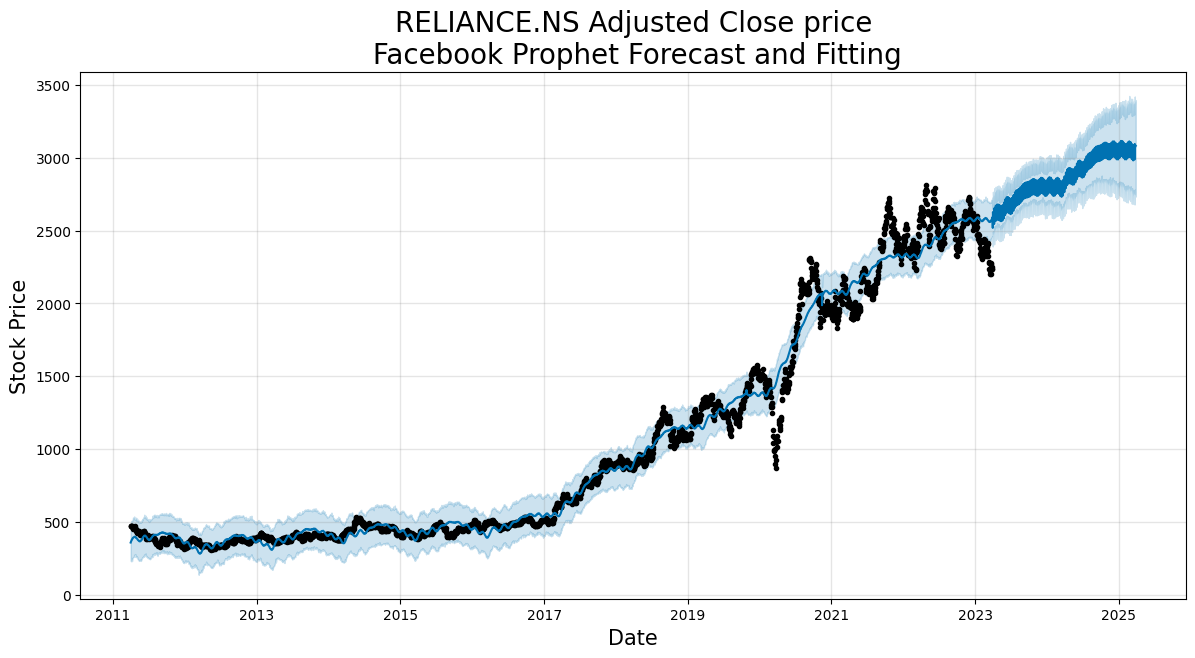

In [26]:
# Plot Forecast and Actual prices  
m.plot(forecast, uncertainty=True, figsize=(12,6))
plt.title('RELIANCE.NS Adjusted Close price\n Facebook Prophet Forecast and Fitting', color = 'black', fontsize = 20)
plt.xlabel("Date", color = 'black', fontsize = 15)
plt.ylabel("Stock Price", color = 'black', fontsize = 15)
plt.show()

In the above plot:
*   Blue line = Forecasted values
*   Black dots = Observed (actual) values
*   Blue-shaded region = Confidence interval


### Trend Changepoints

Time series frequently have abrupt changes in their trajectories. By default, Prophet will automatically detect these changepoints and will allow the trend to adapt appropriately.

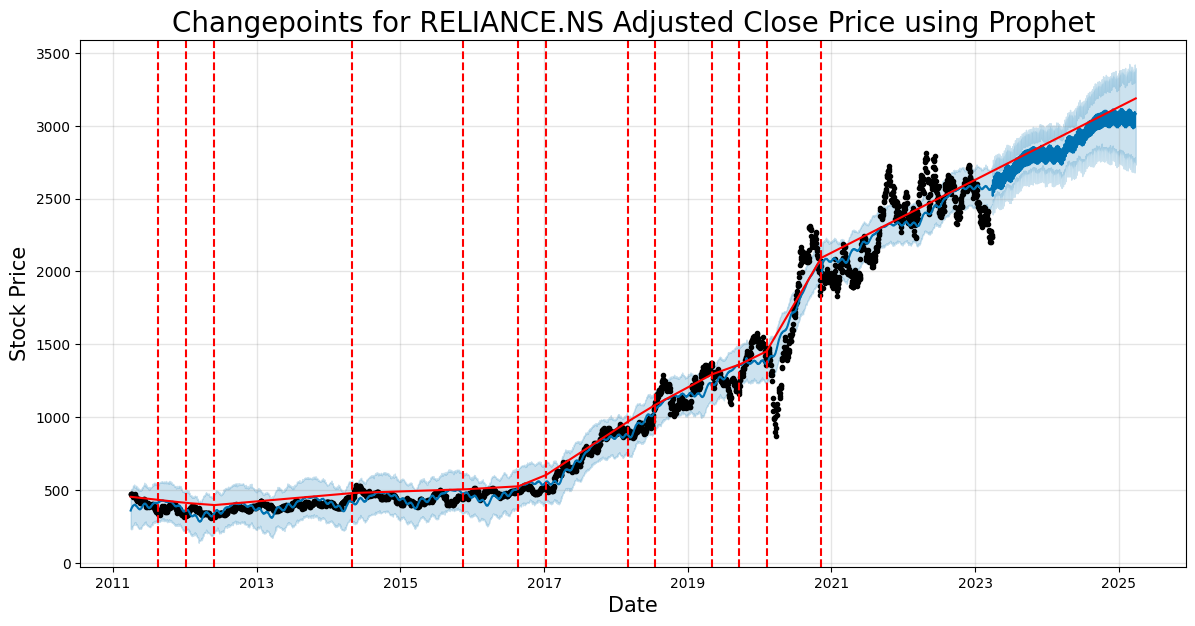

In [28]:
from prophet.plot import add_changepoints_to_plot

fig = m.plot(forecast, figsize=(12,6))
# the change points are added to our plot 
a = add_changepoints_to_plot(fig.gca(), m, forecast)
plt.title("Changepoints for RELIANCE.NS Adjusted Close Price using Prophet", color = 'black', fontsize = 20)
plt.xlabel("Date", color = 'black', fontsize = 15)
plt.ylabel("Stock Price", color = 'black', fontsize = 15)
plt.show()

By default, Prophet adds 25 changepoints into the initial 80% of the data set. Taking a look at the possible changepoints (dotted red lines) in the above chart, we can see they fit quite well with some of the highs and lows.

### Plot magnitudes of changepoints

Prophet will also let us take a look at the magnitudes of these possible changepoints.

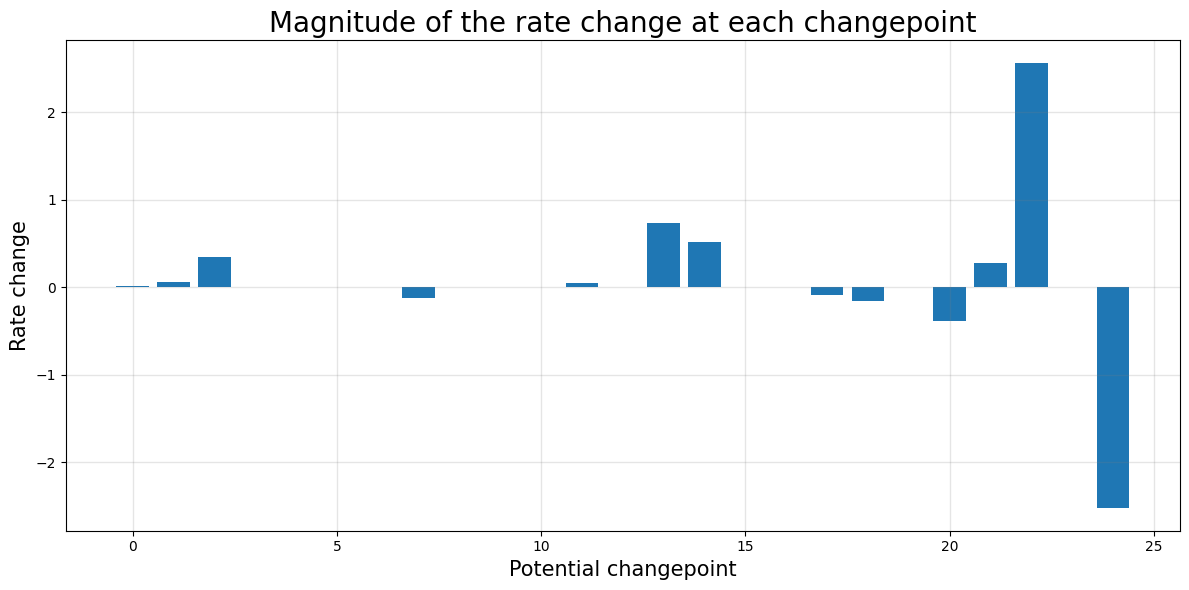

In [29]:
deltas = m.params['delta'].mean(0) 
fig = plt.figure(facecolor='w', figsize=(12,6))
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
plt.title('Magnitude of the rate change at each changepoint', color = 'black', fontsize = 20)
ax.set_ylabel('Rate change', color = 'black', fontsize = 15)
ax.set_xlabel('Potential changepoint', color = 'black', fontsize = 15)
fig.tight_layout()

We can see that the red dotted lines in the plot of changepoints correspond with plot above of the magnitude of the rate change at each changepoint. Even though we have a lot of places where the rate can possibly change, because of the sparse prior, most of these changepoints go unused.

### Extract changepoints

If we want to use something like this in a model, we need a way of extracting changepoint data.

In [30]:
# View changepoints

m.changepoints

95     2011-08-18
189    2012-01-09
284    2012-05-29
378    2012-10-12
473    2013-03-04
568    2013-07-22
662    2013-12-10
757    2014-04-30
851    2014-09-15
946    2015-02-06
1041   2015-06-29
1135   2015-11-16
1230   2016-04-05
1324   2016-08-22
1419   2017-01-10
1514   2017-05-31
1608   2017-10-16
1703   2018-03-05
1797   2018-07-18
1892   2018-12-10
1987   2019-05-03
2081   2019-09-19
2176   2020-02-06
2270   2020-06-29
2365   2020-11-10
Name: ds, dtype: datetime64[ns]

### Plot components of the forecasts

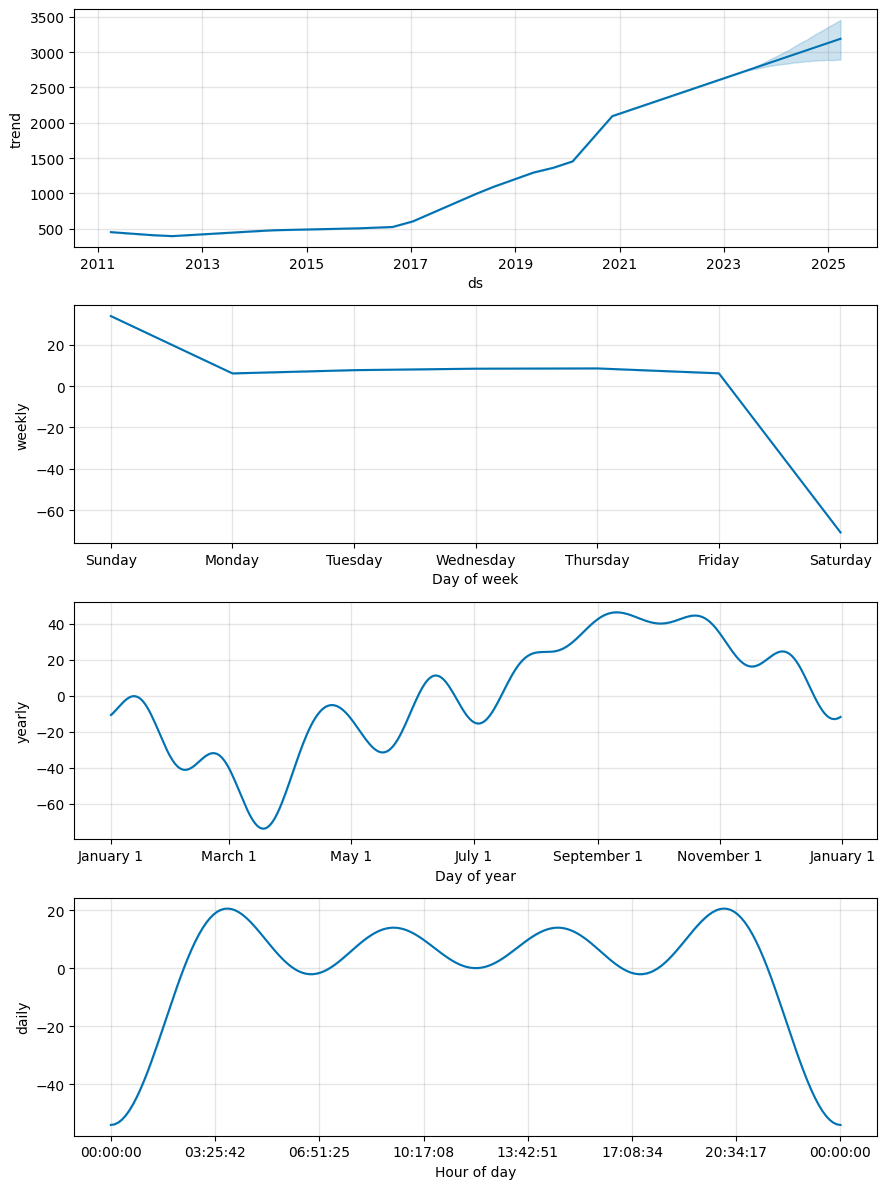

In [31]:
# Plot the trend, weekly, yearly and daily components

m.plot_components(forecast)
plt.show()

Our data has some seasonal information present. Based on the estimated trends, we can see from the yearly subplot that, usually, the stock price is highest in mid-September and, according to the weekly subplot, mostly on Mondays and Fridays. Inevitably, the daily subplot shows that the stock price fluctuates throughout the day.

Finally, the trend subplot shows an upward trend including an increase in the stock price between mid 2020 and beginning of 2022). The dataset only contained data up to the end of 2019 so this prediction does not reflect any impact of Covid-19.